# How close are previous algorithms to the smallest possible sample size and how much closer can we get with SampLNS

We don't know the actual smallest possible sample sizes, but we have a lower bound that we can use.


Let us first load the data from the experiment with solved each of the 44 small to medium instance 5 times with each of the previous algorithms. Then these samples were optimized for 900s by SampLNS.

In [1]:
import pandas as pd

data = pd.read_json("./05_clean_data.json.zip")

In [2]:
data

,instance,#Variables,#Clauses,iteration_info,baseline_alg,initial_sample_path,initial_sample_size,lower_bound,optimized_sample_size
0,calculate,9,15,"[{'nbrhd_tuples': 38, 'nbrhd_confs': 9, 'itera...",FIDE-ICPL,2023-03-01_13-51-03/1_1_0_1_sample.csv,9,5,5
1,calculate,9,15,"[{'nbrhd_tuples': 38, 'nbrhd_confs': 9, 'itera...",FIDE-ICPL,2023-03-01_13-51-03/1_1_0_2_sample.csv,9,5,5
2,calculate,9,15,"[{'nbrhd_tuples': 38, 'nbrhd_confs': 9, 'itera...",FIDE-ICPL,2023-03-01_13-51-03/1_1_0_3_sample.csv,9,5,5
3,calculate,9,15,"[{'nbrhd_tuples': 38, 'nbrhd_confs': 9, 'itera...",FIDE-ICPL,2023-03-01_13-51-03/1_1_0_4_sample.csv,9,5,5
4,calculate,9,15,"[{'nbrhd_tuples': 38, 'nbrhd_confs': 9, 'itera...",FIDE-ICPL,2023-03-01_13-51-03/1_1_0_5_sample.csv,9,5,5
...,...,...,...,...,...,...,...,...,...
95,berkeleyDB2,119,346,"[{'nbrhd_tuples': 204, 'nbrhd_confs': 5, 'iter...",FIDE-ICPL,2023-03-01_13-51-03/20_1_0_1_sample.csv,24,11,14
96,berkeleyDB2,119,346,"[{'nbrhd_tuples': 244, 'nbrhd_confs': 6, 'iter...",FIDE-ICPL,2023-03-01_13-51-03/20_1_0_2_sample.csv,24,11,14
97,berkeleyDB2,119,346,"[{'nbrhd_tuples': 247, 'nbrhd_confs': 4, 'iter...",FIDE-ICPL,2023-03-01_13-51-03/20_1_0_3_sample.csv,24,11,14
98,berkeleyDB2,119,346,"[{'nbrhd_tuples': 98, 'nbrhd_confs': 4, 'itera...",FIDE-ICPL,2023-03-01_13-51-03/20_1_0_4_sample.csv,24,10,15


We extend the values by the best values we know.

In [3]:
# Find the best values for each instance as reference.
best_solutions = (
    data[["instance", "initial_sample_size", "optimized_sample_size"]]
    .groupby("instance")
    .min()
    .reset_index()
    .rename(
        columns={
            "initial_sample_size": "best_baseline",
            "optimized_sample_size": "best_lns_ub",
        }
    )
)
best_lb = (
    data[["instance", "lower_bound"]]
    .groupby("instance")
    .max()
    .reset_index()
    .rename(columns={"lower_bound": "best_lb"})
)
best_values = best_solutions.merge(best_lb, left_on="instance", right_on="instance")
best_values

,instance,best_baseline,best_lns_ub,best_lb
0,APL,12,7,7
1,APL-Model,14,8,8
2,ChatClient,10,7,7
3,FameDB,11,8,8
4,FeatureIDE,16,8,7
5,PPU,15,12,12
6,SafeBali,13,11,11
7,SortingLine,16,9,9
8,TightVNC,17,8,8
9,Violet,30,18,12


In [4]:
# add them to the data as reference
data = data.merge(best_values, left_on="instance", right_on="instance")

In [5]:
# instances that have been solved by all algorithms
instances_intersection = None
for instances in data.groupby(["baseline_alg"])["instance"].unique().to_list():
    if instances_intersection is None:
        instances_intersection = set(instances)
    else:
        instances_intersection &= set(instances)
len(instances_intersection)

20

In [6]:
t = (
    data.groupby(["instance", "baseline_alg"])[
        ["initial_sample_size", "best_lb", "optimized_sample_size"]
    ]
    .mean()
    .reset_index()
)
# t = t[t["instance"].isin(instances_intersection)]
t["sort_key"] = t.apply(
    (
        lambda row: (
            row["baseline_alg"].split("(")[0][::-1],
            len(row["baseline_alg"]),
            row["baseline_alg"],
        )
    ),
    axis=1,
)
t["ub_1"] = 100 * (t["initial_sample_size"] / t["best_lb"] - 1)
t["ub_2"] = 100 * (t["optimized_sample_size"] / t["best_lb"] - 1)
t1 = t.copy()
t1.rename(columns={"ub_1": "ub"}, inplace=True)
t1["SampLNS"] = "Without SampLNS"
t2 = t.copy()
t2.rename(columns={"ub_2": "ub"}, inplace=True)
t2["SampLNS"] = "With SampLNS"
t1.sort_values(by="sort_key", inplace=True)
t2.sort_values(by="sort_key", inplace=True)
t = pd.concat([t1, t2], ignore_index=True).drop(
    columns=["ub_1", "ub_2", "initial_sample_size"]
)
t = t[~t["baseline_alg"].str.contains("FIDE-YASA")]
t["baseline_alg"] = t["baseline_alg"].apply(lambda s: s.split("-")[-1])

In [7]:
t

,instance,baseline_alg,best_lb,optimized_sample_size,sort_key,ub,SampLNS
0,APL,ICPL,7.0,7.0,"(LPCI-EDIF, 9, FIDE-ICPL)",71.428571,Without SampLNS
1,gpl,ICPL,16.0,16.0,"(LPCI-EDIF, 9, FIDE-ICPL)",43.750000,Without SampLNS
2,email,ICPL,6.0,6.0,"(LPCI-EDIF, 9, FIDE-ICPL)",33.333333,Without SampLNS
3,dell,ICPL,31.0,31.0,"(LPCI-EDIF, 9, FIDE-ICPL)",29.032258,Without SampLNS
4,car,ICPL,5.0,5.0,"(LPCI-EDIF, 9, FIDE-ICPL)",20.000000,Without SampLNS
5,calculate,ICPL,5.0,5.0,"(LPCI-EDIF, 9, FIDE-ICPL)",80.000000,Without SampLNS
6,berkeleyDB2,ICPL,11.0,14.2,"(LPCI-EDIF, 9, FIDE-ICPL)",118.181818,Without SampLNS
7,berkeleyDB1,ICPL,12.0,15.2,"(LPCI-EDIF, 9, FIDE-ICPL)",100.000000,Without SampLNS
8,axTLS,ICPL,10.0,11.0,"(LPCI-EDIF, 9, FIDE-ICPL)",70.000000,Without SampLNS
9,Violet,ICPL,12.0,18.4,"(LPCI-EDIF, 9, FIDE-ICPL)",150.000000,Without SampLNS


In [8]:
# Prepare plotting
import seaborn as sns

sns.set_theme()
import matplotlib.pyplot as plt

FileNotFoundError: [Errno 2] No such file or directory: './plots/01_11_how_much_above_lb_stripplot.pdf'

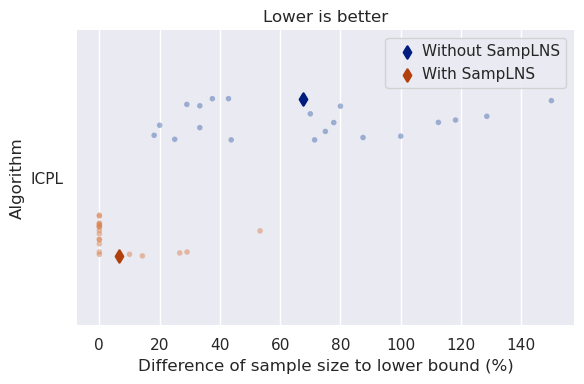

In [9]:
f, ax = plt.subplots(figsize=(6, 4))
sns.despine(bottom=True, left=True)
sns.stripplot(
    data=t,
    y="baseline_alg",
    x="ub",
    hue="SampLNS",
    dodge=True,
    alpha=0.5,
    zorder=1,
    legend=False,
    size=4,
    jitter=0.15,
)
sns.pointplot(
    data=t[t["instance"].isin(instances_intersection)],
    x="ub",
    y="baseline_alg",
    hue="SampLNS",
    join=False,
    dodge=0.8 - 0.8 / 3,
    palette="dark",
    markers="d",
    scale=0.9,
    errorbar=None,
)
sns.move_legend(
    ax,
    loc="upper right",
    ncol=1,
    frameon=True,
    columnspacing=1,
    handletextpad=0,
    title=None,
)
plt.title("Lower is better")
plt.xlabel("Difference of sample size to lower bound (%)")
plt.ylabel("Algorithm")
plt.tight_layout()
plt.savefig("./plots/01_11_how_much_above_lb_stripplot.pdf")
plt.show()

In [ ]:
t[t["instance"].isin(instances_intersection)].groupby(["baseline_alg", "SampLNS"])[
    ["ub"]
].mean()

ub
baseline_alg SampLNS                    
Chvatal      With SampLNS       4.830468
             Without SampLNS   86.386708
ICPL         With SampLNS       4.858994
             Without SampLNS   84.422865
Incling      With SampLNS       4.872206
             Without SampLNS  103.455521
YASA(m=1)    With SampLNS       4.828393
             Without SampLNS   60.271626
YASA(m=10)   With SampLNS       4.673197
             Without SampLNS   46.644419
YASA(m=3)    With SampLNS       4.744340
             Without SampLNS   51.568337
YASA(m=5)    With SampLNS       4.675897
             Without SampLNS   49.254518

In [ ]:
t_ = (
    t[t["instance"].isin(instances_intersection)]
    .groupby(["instance", "baseline_alg", "SampLNS"])[["ub"]]
    .mean()
)
t_["c"] = t_["ub"] == 0.0
t_.reset_index().groupby(["baseline_alg", "SampLNS"])[["c"]].sum()

c
baseline_alg SampLNS            
Chvatal      With SampLNS     24
             Without SampLNS   0
ICPL         With SampLNS     23
             Without SampLNS   0
Incling      With SampLNS     23
             Without SampLNS   1
YASA(m=1)    With SampLNS     24
             Without SampLNS   2
YASA(m=10)   With SampLNS     24
             Without SampLNS   3
YASA(m=3)    With SampLNS     23
             Without SampLNS   3
YASA(m=5)    With SampLNS     22
             Without SampLNS   3

In [ ]:
t_ = (
    t[t["instance"].isin(instances_intersection)]
    .groupby(["instance", "baseline_alg", "SampLNS"])[["ub"]]
    .mean()
)
t_["c"] = t_["ub"] <= 20.0
t_.reset_index().groupby(["baseline_alg", "SampLNS"])[["c"]].sum()

c
baseline_alg SampLNS            
Chvatal      With SampLNS     31
             Without SampLNS   3
ICPL         With SampLNS     31
             Without SampLNS   4
Incling      With SampLNS     31
             Without SampLNS   2
YASA(m=1)    With SampLNS     31
             Without SampLNS   6
YASA(m=10)   With SampLNS     31
             Without SampLNS  11
YASA(m=3)    With SampLNS     31
             Without SampLNS   9
YASA(m=5)    With SampLNS     31
             Without SampLNS  10